# Naive Bayes Multinomial (Sentiment Review Prediction)
Penjelasan Kolom:
1. Reviews: Teks lengkap dari ulasan yang ditulis oleh pengguna.
2. Ratings: Jumlah bintang (rating) yang diberikan pengguna. Nilai berkisar dari 1 hingga 5.

## A. Data Preparation

### A.1 Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### A.2 Load Data

In [2]:
import pandas as pd
import numpy as np

# 1. Load Data
df = pd.read_csv('Call Of Duty.csv')

### A.3 Mengecek Dimensi Data

In [3]:
df.shape

(3882, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3882 entries, 0 to 3881
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   reviews  3882 non-null   object
 1   ratings  3882 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 60.8+ KB


In [5]:
df.head()

,reviews,ratings
0,I've been playing for years now and it's been ...,4
1,An annoying experience all round. Ever since t...,1
2,"I love the game though. It's close to real, bu...",3
3,I've been playing for years now and it's been ...,4
4,An annoying experience all round. Ever since t...,1


## B. Data Preprocessing

In [6]:
df.columns

Index(['reviews', 'ratings'], dtype='object')

In [7]:

def preprocess_text(text_series):
    # 1. Case Folding/Normalization (Jadikan huruf kecil)
    # 2. Text Cleaning (Hapus angka/simbol aneh)
    # 3. Remove Punctuation (Hapus tanda baca)
    # 4. Tokenization (Split jadi list kata)
    temp_tokens = text_series.str.lower().str.replace(r'[^a-z\s]', ' ', regex=True).str.strip()
    return temp_tokens

df['reviews_clean'] = preprocess_text(df['reviews'])

In [8]:
df['reviews_clean'].unique()

array(['i ve been playing for years now and it s been quite addictive     but can u the developers just plss fix the issue of i not seeing enemies at far distances which always makes me vulnerable to surprise attacks     and also i ve always had the privilege in past to play with high frame rate but now it s only low frame rate i can use to play which s depressing',
       'an annoying experience all round  ever since the update for season     wild dogs   i have been unable to enjoy a game without the game running like a cracked cd  for the interests of the player and developer  i suggest you reverse whatever   upgrade   was done  don t forget that when you continually buff up the storage size of games and run time  the phones remain the same  i must not necessarily have a high end thousand dollar devices to play your game',
       'i love the game though  it s close to real  but the greatest problem is the consistent upgrades with very large storage taken  it reduces the functionality

## C. Exploratory Data Analysis (EDA)

### C.1 Mengecek Sample Target (Rating)

In [9]:
df.columns

Index(['reviews', 'ratings', 'reviews_clean'], dtype='object')

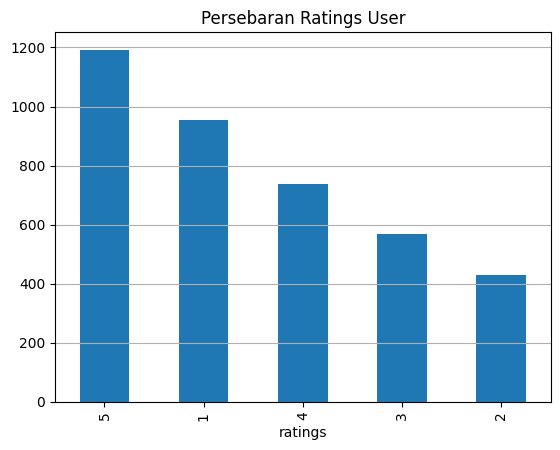

In [10]:
df['ratings'].value_counts().plot(kind='bar').set_title("Persebaran Ratings User")
plt.grid(axis='y')
plt.show()

### C.2 Mengecek Korelasi Reviews dengan Ratings

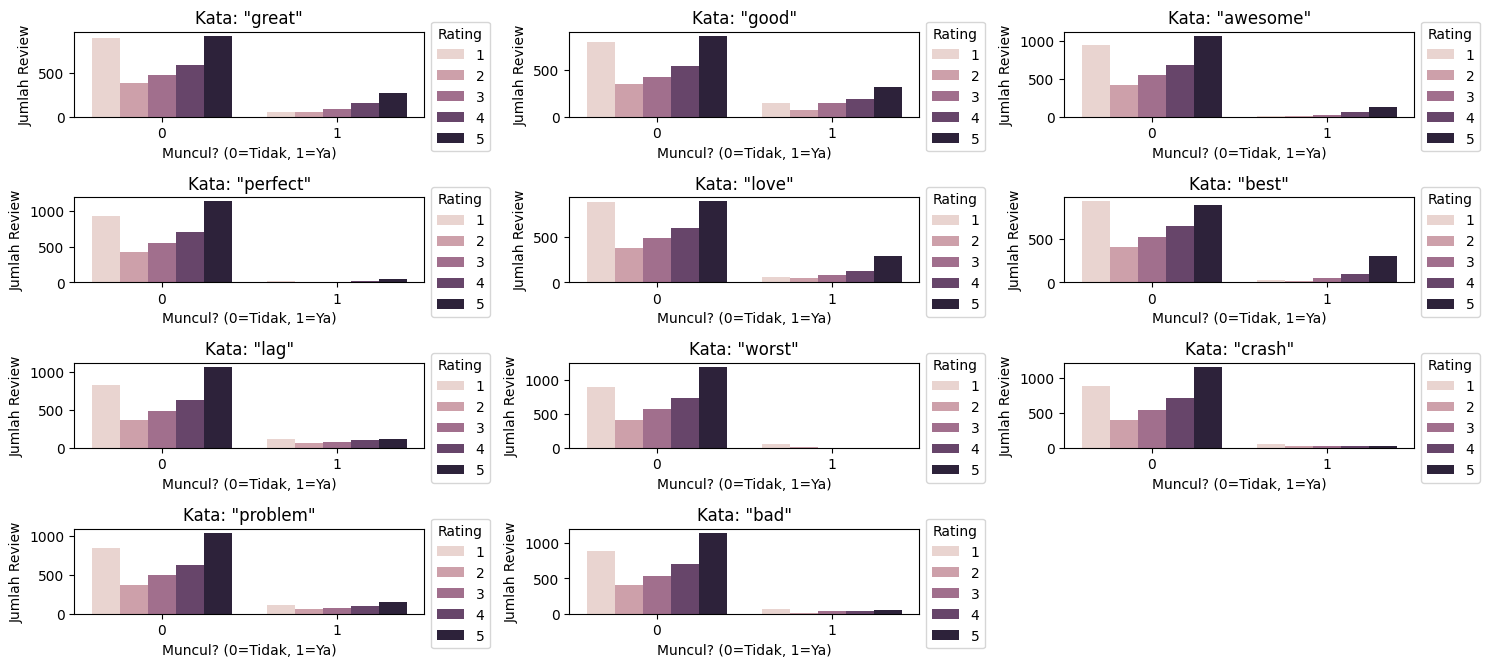

In [11]:
review_words = ['great','good','awesome','perfect','love','best','lag','worst','crash', 'problem', 'bad']
target = 'ratings'

plt.figure(figsize=(15, 8))

for i, kata in enumerate(review_words):
    # Langkah A: Bikin kolom baru (0 jika gak ada, 1 jika ada)
    # Kita pakai str(x).lower() biar "Good" dan "good" dianggap sama
    df[kata] = df['reviews_clean'].apply(lambda x: 1 if kata in str(x).lower() else 0)
    
    # Langkah B: Gambar Grafik di posisi yang benar
    plt.subplot(5, 3, i + 1)
    sns.countplot(x=kata, hue=target, data=df)
    plt.legend(title='Rating', bbox_to_anchor=(1, 1.2))
    plt.title(f'Kata: "{kata}"')
    plt.xlabel(f'Muncul? (0=Tidak, 1=Ya)')
    plt.ylabel('Jumlah Review')

plt.tight_layout()
plt.show()

## D. Modelling

### D.1 Membuat Variabel X dan Y

In [12]:
X = df['reviews_clean']
y = df['ratings']

### D.2 Splitting Data Training dan Data Test

In [13]:
def stratified_split_data(X, y, train_size=0.8, random_state=42, frac=None):
    np.random.seed(random_state)
    
    if frac:
        X = X.sample(frac=frac, random_state=random_state)
        y = y.loc[X.index]
        
    X_train_list, X_test_list = [], []
    y_train_list, y_test_list = [], []
    
    for class_value in np.unique(y):
        class_idx = np.where(y == class_value)[0]
        
        idx = np.random.permutation(class_idx)
        split_ratio = int(len(idx) * train_size)
        
        X_train_list.append(X.iloc[idx[:split_ratio]])
        X_test_list.append(X.iloc[idx[split_ratio:]])
        y_train_list.append(y.iloc[idx[:split_ratio]])
        y_test_list.append(y.iloc[idx[split_ratio:]])
        
    X_train = pd.concat(X_train_list).reset_index(drop=True)
    X_test = pd.concat(X_test_list).reset_index(drop=True)
    y_train = pd.concat(y_train_list).reset_index(drop=True)
    y_test = pd.concat(y_test_list).reset_index(drop=True)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = stratified_split_data(X, y )

print("Shape X_train:", X_train.shape) 
# Sekarang outputnya pasti (jumlah_baris, jumlah_vocab), misal (3105, 9600).
# Error "unpack" tidak akan muncul lagi karena sudah 2 Dimensi.

Shape X_train: (3104,)


### D.3 TF - IDF Formulas

#### Membangun Kamus/Vocabulary

In [14]:
def build_vocabulary(text_series, min_count=2):
    # 1. Hitung Frekuensi (Pake Pandas Series)
    # Gabung spasi, split jadi list, langsung hitung
    counts = pd.Series(" ".join(text_series).split()).value_counts()
    
    # 2. Filter & Sort
    # Ambil index (kata) yang jumlahnya >= min_count, lalu urutkan abjad
    valid_words = sorted(counts[counts >= min_count].index)
    
    # 3. Indexing (Dictionary Comprehension)
    return {w: i for i, w in enumerate(valid_words)}

#### Menghitung TF (Term Frequency)

In [15]:
def calculate_tf(text_series, vocab_index):
    n_docs = len(text_series)
    n_vocab = len(vocab_index)
    
    # Matriks Kosong untuk TF
    tf_matrix = np.zeros((n_docs, n_vocab))
    
    for row, text in enumerate(text_series):
        words = text.split()
        for w in words:
            # Jika kata ada di kamus, tambahkan hitungannya (+1)
            if w in vocab_index:
                col_idx = vocab_index[w]
                tf_matrix[row, col_idx] += 1
                
    return tf_matrix

#### Menghitung IDF (Inverse Document Frequency)

In [16]:
def calculate_idf(text_series, vocab_index):
    n_docs = len(text_series)
    df_counts = dict.fromkeys(vocab_index.keys(), 0)
    
    for text in text_series:
        for word in set(text.split()):
            if word in df_counts:
                df_counts[word] += 1
                
    return {word: np.log(n_docs / (count + 1)) for word, count in df_counts.items()}

#### Menghitung TF-IDF

In [17]:
def multiply_tf_idf(tf_matrix, vocab_index, idf_values):
    # 1. Copy biar aman
    matrix = tf_matrix.copy()
    
    # 2. Loop per Kata (Kolom)
    for w, col_idx in vocab_index.items():
        # Kolom dikali Skalar IDF
        matrix[:, col_idx] *= idf_values[w]
        
    return matrix

#### Menjalankan Semua Methods TF-IDF + Normalisasi

In [18]:
def normalize_l2(matrix):
    norms = np.sqrt(np.sum(matrix**2, axis=1, keepdims=True))
    norms[norms == 0] = 1
    return matrix / norms

In [19]:
# 1. Bikin Kamus
vocab_index = build_vocabulary(X_train)

# 2. Hitung IDF
idf_values = calculate_idf(X_train, vocab_index)

# 3. Hitung TF Train & Test
tf_train = calculate_tf(X_train, vocab_index)
tf_test = calculate_tf(X_test, vocab_index)

# 4. Kalikan jadi TF-IDF Train & TF-IDF Test
X_train_matrix = multiply_tf_idf(tf_train, vocab_index, idf_values)
X_test_matrix = multiply_tf_idf(tf_test, vocab_index, idf_values)

X_train_matrix = normalize_l2(X_train_matrix)
X_test_matrix = normalize_l2(X_test_matrix)

print(f"Dimensi Train: {X_train_matrix.shape}")
print(f"Dimensi Test : {X_test_matrix.shape}")

Dimensi Train: (3104, 3804)
Dimensi Test : (778, 3804)


### D.3 Membuat Class NaiveBayesMultinomial

In [20]:
class NaiveBayesMultinomial:
    def __init__(self, alpha=1.0):
        self.alpha = alpha

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)
        
        # Siapkan container
        self._priors = np.zeros(n_classes)
        self._feature_probs = np.zeros((n_classes, n_features))
        
        for idx, c in enumerate(self._classes):
            X_c = X[y == c]
            
            # 1. Prior
            self._priors[idx] = X_c.shape[0] / n_samples
            
            # 2. Likelihood (Pecah biar juri paham)
            numerator = X_c.sum(axis=0) + self.alpha
            denominator = X_c.sum() + (self.alpha * n_features)
            
            self._feature_probs[idx] = numerator / denominator

    def _predict_one(self, x):
        posteriors = []
        for idx, c in enumerate(self._classes):
            # Log-Sum-Exp Trick
            prior = np.log(self._priors[idx])
            likelihood = np.sum(x * np.log(self._feature_probs[idx]))
            posterior = prior + likelihood
            posteriors.append(posterior)
        return self._classes[np.argmax(posteriors)]

    def predict(self, X):
        return np.array([self._predict_one(x) for x in X])

In [21]:
best_acc = 0
best_alpha = 0

list_alpha = [0.1, 0.5, 1, 2, 3, 4, 5]

for a in list_alpha:
    nbm = NaiveBayesMultinomial(a)
    nbm.fit(tf_train, y_train)
    pred = nbm.predict(tf_test)
    acc = np.mean(pred == y_test)
    print(f"|   {acc}   |   {a}   |")
    
    if acc > best_acc:
        best_acc = acc
        best_alpha = a
        
print(f"|   Best Acc: {best_acc}     |   Best Alpha: {best_alpha}   |")

|   0.4254498714652956   |   0.1   |
|   0.442159383033419   |   0.5   |
|   0.461439588688946   |   1   |
|   0.46786632390745503   |   2   |
|   0.480719794344473   |   3   |
|   0.47429305912596403   |   4   |
|   0.47429305912596403   |   5   |
|   Best Acc: 0.480719794344473     |   Best Alpha: 3   |


## E. Evaluasi Model

### E.1 Evaluasi Akurasi Test & Train

In [22]:
nbm = NaiveBayesMultinomial(3)
nbm.fit(tf_train, y_train) 
print("nbm berhasil dilatih!")

nbm berhasil dilatih!


In [23]:
predictions = nbm.predict(X_test_matrix)

In [24]:
test_accuracy = np.mean(predictions == y_test)
test_accuracy

np.float64(0.4845758354755784)

In [25]:
predictions_train = nbm.predict(X_train_matrix)

In [26]:
train_accuracy = np.mean(predictions_train == y_train)
print(train_accuracy)

0.685889175257732


### E.2 Evaluasi Precision, Recall, Confusion Matrix

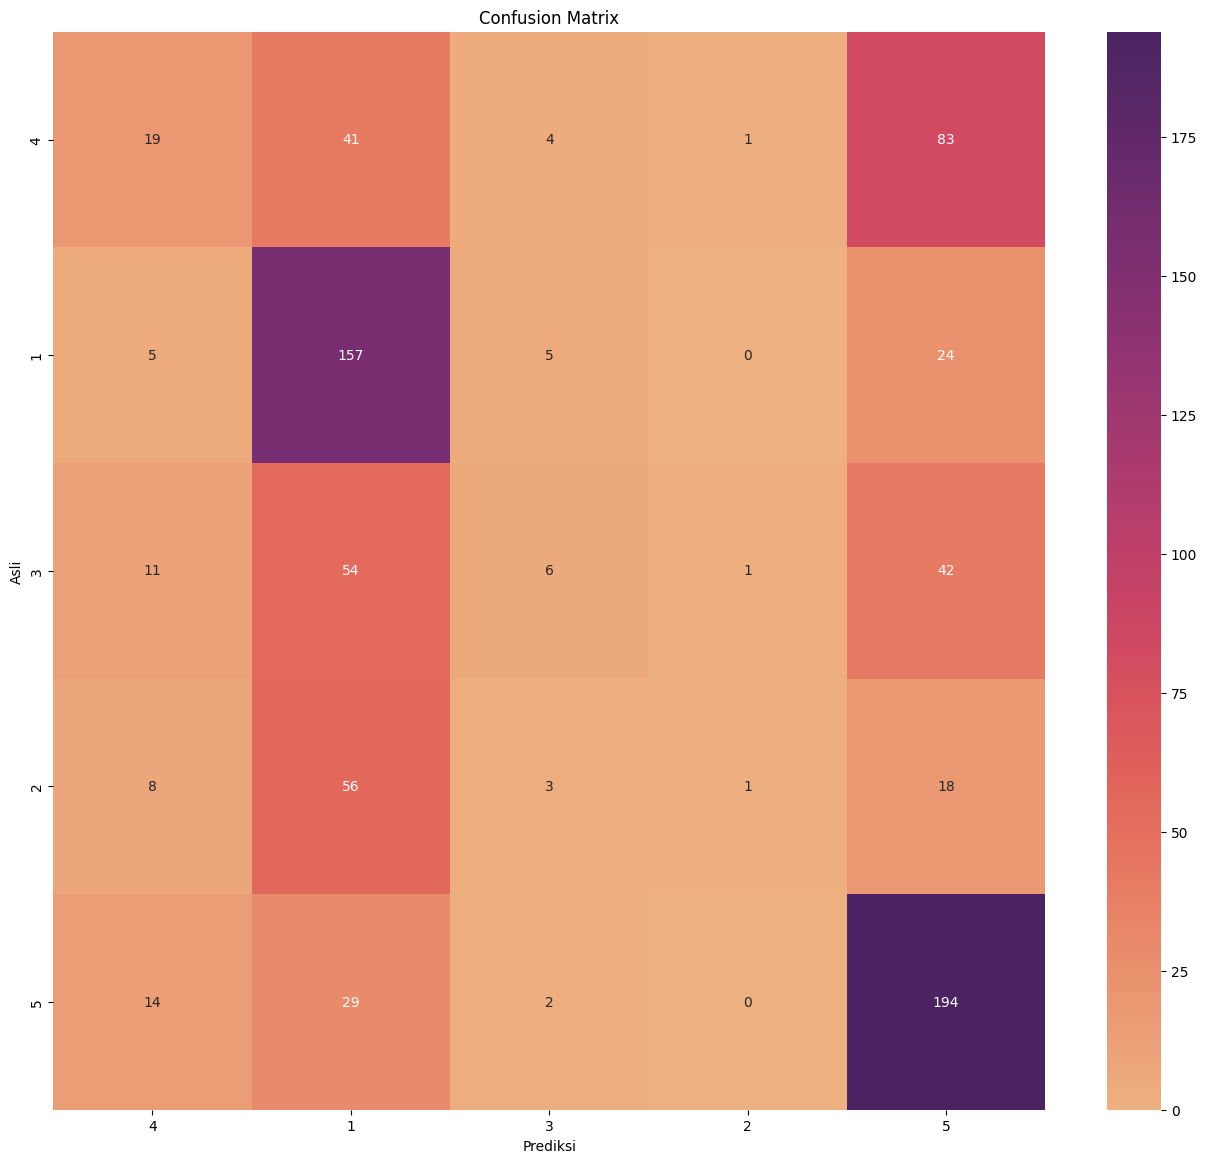

TP = 19, FP = 38, FN = 38, TN = 592
TP = 157, FP = 180, FN = 180, TN = 407
TP = 6, FP = 14, FN = 14, TN = 650
TP = 1, FP = 2, FN = 2, TN = 690
TP = 194, FP = 167, FN = 167, TN = 372


In [27]:
label_name = df['ratings'].unique()
n_classes = len(label_name)

cm = np.zeros((n_classes, n_classes), dtype=int)
label_to_index = {label: i for i, label in enumerate(label_name)}

for true, pred in zip(y_test, predictions):
    idx_true = label_to_index[true]
    idx_pred = label_to_index[pred]
    cm[idx_true][idx_pred] += 1


TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP
TN = np.sum(cm) - (TP + FP + FN)


plt.figure(figsize=(16,14))
sns.heatmap(cm, annot=True, cmap='flare', fmt='d', xticklabels=label_name, yticklabels=label_name)
plt.xlabel("Prediksi")
plt.ylabel("Asli")
plt.title("Confusion Matrix")

plt.show()
for i, name in enumerate(label_name):
    print(f"TP = {TP[i]}, FP = {FP[i]}, FN = {FP[i]}, TN = {TN[i]}")
    

In [28]:
precision = TP + (TP / FP)
precision = np.mean(precision)
precision

np.float64(76.09249405950004)

In [29]:
recall = TP + (TP / FN)
recall = np.mean(recall)
recall

np.float64(77.22867305061558)

In [30]:
f1 = 2 * (precision * recall) / (precision + recall)
f1

np.float64(76.65637375570596)

### E.3 Evaluasi Data Baru (GUI)

In [31]:
# import tkinter as tk
# from tkinter import *
# from tkinter import messagebox


# try:
#     model = nbm
#     print("Berhasil memanggil model")
# except Exception as e:
#     model = None
#     print("Gagal mengambil model")

# def cek_data_baru():
#     data_baru = entry_data.get("1.0", tk.END).strip()
        
#     if not data_baru:
#         messagebox.showwarning('Input kosong', 'tolong input data yang benar')
#         return
    
#     hasil = model.predict_single(data_baru, idf_values)
        
#     label_hasil.config(text=f"Rating: {hasil}", fg='blue')

# # GUI UTAMA
# root = tk.Tk()

# root.title("Prediksi Naive Bayes Multinomial")
# root.geometry("700x600")
# root.configure(bg="lightblue")

# judul = Label(root,text="Prediksi Sentimen Review", font=("Arial", 20, "bold"), bg="lightblue")
# judul.pack()

# deskripsi = Label(root,text="Naive Bayes Multinomial", font=("Arial", 10, "underline"), bg="lightblue")
# deskripsi.pack(pady=(0, 30))

# entry_data = Text(root, width=40, height=20, bg="gray", fg="white")
# entry_data.pack()

# enter_data = Button(text="Kirim Teks", command=cek_data_baru)
# enter_data.pack(pady=30)

# label_hasil = Label(text="...")
# label_hasil.pack()

# root.mainloop()

In [32]:
# import tkinter as tk
# from tkinter import *

# def run_predict():
#     txt = entry.get("1.0", END).strip()
#     if not txt: return

#     # Pipeline Manual
#     clean = preprocess_text(pd.Series([txt]))
#     tf = calculate_tf(clean, vocab_index)
#     tfidf = multiply_tf_idf(tf, vocab_index, idf_values)
#     pred = model.predict(tfidf)[0]
    
#     lbl_out.config(text=f"Rating: {pred}", fg="blue")

# # Setup UI Simple
# root = Tk()
# root.geometry("500x400")
# root.title("NBM Call of Duty")

# Label(root, text="Input Review:", font=("Arial", 12)).pack(pady=10)
# entry = Text(root, height=5, width=50)
# entry.pack()

# Button(root, text="PREDIKSI", command=run_predict, bg="green", fg="white").pack(pady=10)
# lbl_out = Label(root, text="...", font=("Arial", 20, "bold"))
# lbl_out.pack(pady=20)

# root.mainloop()